# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Thumbs up:  Increase the volume
Thumbs down: Decrease the volume
Left swipe: 'Jump' backwards 10 seconds
Right swipe: 'Jump' forward 10 seconds  
Stop: Pause the movie

For analysing videos using neural networks, two types of architectures are used commonly. One is the standard CNN + RNN architecture in which you pass the images of a video through a CNN which extracts a feature vector for each image, and then pass the sequence of these feature vectors through an RNN. This is something you are already familiar with (in theory).

The other popular architecture used to process videos is a natural extension of CNNs - a 3D convolutional network. In this project, you will try both these architectures. 

In [1]:
#pip install opencv-python

In [1]:
from scipy import misc

In [2]:
import numpy as np
import os
#from scipy.misc import imresize
from imageio import imread
from skimage.transform import resize as imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.compat.v1.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
folder_path = '/home/datasets/Project_data'
train_doc = np.random.permutation(open(folder_path+'/'+'train.csv').readlines())
val_doc = np.random.permutation(open(folder_path+'/'+'val.csv').readlines())
batch_size = 20 #experiment with the batch size
train_data_path = folder_path+'/'+'train'
val_data_path = folder_path+'/'+'val'

In [5]:
# Default parameters
num_channel = 3
num_class = 5
num_total_frame = 30



In [6]:
# Default parameters
img_height = 160
img_width = 160
frame_to_sample = 30
batch_size = 20

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def single_batch_data(source_path, t, batch,batch_size,img_idx,is_augmentation,remaining_seq=0):
            seq_len = remaining_seq if remaining_seq else batch_size
            batch_data = np.zeros((seq_len,len(img_idx),img_height,img_width,num_channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((seq_len,num_class)) # batch_labels is the one hot representation of the output
           
            if (is_augmentation): 
                batch_data_augmentation = np.zeros((seq_len,len(img_idx),img_height,img_width,num_channel))

        
            for folder in range(seq_len): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = imresize(image, (img_height, img_width,3))
                    
                    batch_data[folder,idx,:,:,0] = image_resized[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_resized[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_resized[:,:,2]/255#normalise and feed in the image
                    
                    if(is_augmentation):
                        num_rows, num_cols = image.shape[:2] 
                        translation_matrix = np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]])  
                        
                        img_translation = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
                        
                        gray_img = cv2.cvtColor(img_translation, cv2.COLOR_BGR2GRAY)
                        
                        x0, y0 = np.argwhere(gray_img > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray_img > 0).max(axis=0) 
                        
                        crop_img=img_translation[x0:x1,y0:y1,:]
                        
                        image_resized = imresize(crop_img, (img_height, img_width,3))
                    
                        batch_data_augmentation[folder,idx,:,:,0] = image_resized[:,:,0]/255 #normalise and feed in the image
                        batch_data_augmentation[folder,idx,:,:,1] = image_resized[:,:,1]/255#normalise and feed in the image
                        batch_data_augmentation[folder,idx,:,:,2] = image_resized[:,:,2]/255#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            if (is_augmentation):
                batch_data=np.concatenate([batch_data,batch_data_augmentation])
                batch_labels=np.concatenate([batch_labels,batch_labels])
                
            return(batch_data,batch_labels)

In [25]:
def generator(source_path, folder_list, batch_size,is_augmentation = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,num_total_frame-1,frame_to_sample)).astype(int)
    print(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data,batch_labels = single_batch_data(source_path,t,batch,batch_size,img_idx,is_augmentation)
            yield batch_data, batch_labels 
            
        remaining_batch=len(t)%batch_size
        if (remaining_batch != 0):
            batch_data, batch_labels= single_batch_data(source_path,t,num_batches,batch_size,img_idx,is_augmentation,remaining_batch)
            yield batch_data, batch_labels     

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = folder_path+'/'+'train'
val_path = folder_path+'/'+'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [10]:
def train_model(model,augment=False):
    # Let us create the train_generator and the val_generator which will be used in .fit_generator.
    train_generator = generator(train_path, train_doc, batch_size,augment)
    val_generator = generator(val_path, val_doc, batch_size)
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    
    # The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    # Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    return history
    

## Test generator and cropping.

Source path =  /home/datasets/Project_data/val ; batch size = 5
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


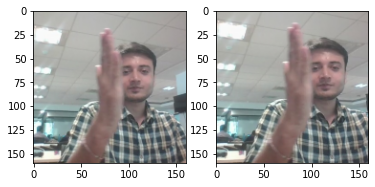

In [11]:
batch_size=5

gen_val = generator(val_path,val_doc,batch_size,is_augmentation=True)
batch_data,batch_label = next(gen_val)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[5,15,:,:,:])
# Cropping working fine lets move to next.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

#write your model here

## 3D Convolutional Network, or Conv3D

In [20]:
def get_model(filtersize=(3,3,3),dropout=0.25,dense_neurons=64):
    
    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
                     input_shape=(frame_to_sample,img_height,img_width,num_channel)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_class,activation='softmax'))
    optimiser = 'adam'  #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [21]:
model = get_model()
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 80, 80, 32)    1

## Experimenting with different batchsize,number of frame, image resolution

### Let's check training time affect with changing parameters

In [239]:
# To adjust Hyperparameter

img_height = 120
img_width = 120
frame_to_sample = 20
batch_size = 30
num_epochs = 10

model = get_model()
print("Total Parameter:",model.count_params())
train_model(model)


Total Parameter: 900805
Source path =  ./Project_data/train ; batch size = 30
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.7489 - categorical_accuracy: 0.3908 Source path =  ./Project_data/val ; batch size = 30
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
23/23 [==============================] - 576s 24s/step - loss: 1.7404 - categorical_accuracy: 0.3930 - val_loss: 2.4465 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to model_init_2021-06-2405_25_43.757026/model-00001-1.54526-0.44344-2.44650-0.19000.h5
Epoch 2/10
23/23 [==============================] - 680s 29s/step - loss: 1.1351 - categorical_accuracy: 0.5620 - val_loss: 4.6729 - val_categorical_accuracy: 0.1700

Epoch 00002: saving model to model_init_2021-06-2405_25_43.757026/model-00002-1.13048-0.55053-4.67290-0.17000.h5
Epoch 3/10
23/23 [==============================] - 582s 25s/step - loss: 0.8717 - categori

In [240]:

img_height = 120
img_width = 120
frame_to_sample = 30
batch_size = 15
num_epochs = 10

model = get_model()
print("Total Parameter:", model.count_params())
train_model(model)

Total Parameter: 900805
Source path =  ./Project_data/train ; batch size = 15
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 1.7791 - categorical_accuracy: 0.3544 Source path =  ./Project_data/val ; batch size = 15
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
45/45 [==============================] - 873s 19s/step - loss: 1.7754 - categorical_accuracy: 0.3554 - val_loss: 3.3951 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-06-2405_25_43.757026/model-00001-1.60713-0.40121-3.39513-0.16000.h5
Epoch 2/10
45/45 [==============================] - 1068s 24s/step - loss: 1.1513 - categorical_accuracy: 0.5502 - val_loss: 4.5827 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to model_init_2021-06-2405_25_43.757026/model-00002-1.19071-0.53846-4.58266-0.15000.h5
Epoch 3/10
45/45 [==========

In [16]:
img_height = 160
img_width = 160
frame_to_sample = 30
batch_size = 20
num_epochs = 10
model = get_model()
print("Total Parameter:", model.count_params())
train_model(model)


Total Parameter: 1736389
Source path =  ./Project_data/train ; batch size = 20
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.8617 - categorical_accuracy: 0.3504 Source path =  ./Project_data/val ; batch size = 20
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
34/34 [==============================] - 2057s 59s/step - loss: 1.8548 - categorical_accuracy: 0.3519 - val_loss: 5.5182 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-06-2412_50_30.680974/model-00001-1.61961-0.40271-5.51825-0.16000.h5
Epoch 2/10
34/34 [==============================] - 2509s 73s/step - loss: 1.1433 - categorical_accuracy: 0.5716 - val_loss: 9.1150 - val_categorical_accuracy: 0.1900

Epoch 00002: saving model to model_init_2021-06-2412_50_30.680974/model-00002-1.11768-0.57315-9.11502-0.19000.h5
Epoch 3/10
34/34 [========

In [34]:
img_height = 160
img_width = 160
frame_to_sample = 20
batch_size = 30
num_epochs = 10


model = get_model()
print("Total Parameter:", model.count_params())
train_model(model)

Total Parameter: 1940677
Source path =  /home/datasets/Project_data/train ; batch size = 30
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Epoch 1/10
22/23 [===========================>..] - ETA: 4s - loss: 1.6431 - categorical_accuracy: 0.3924Source path =  /home/datasets/Project_data/val ; batch size = 30
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]

Epoch 00001: saving model to model_init_2021-06-2506_02_56.699119/model-00001-1.63825-0.39367-3.26193-0.17000.h5
23/23 [==============================] - 113s 5s/step - loss: 1.6382 - categorical_accuracy: 0.3937 - val_loss: 3.2619 - val_categorical_accuracy: 0.1700
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.0021 - categorical_accuracy: 0.6139
Epoch 00002: saving model to model_init_2021-06-2506_02_56.699119/model-00002-1.00210-0.61388-4.66918-0.18000.h5
23/23 [==============================] - 112s 5s/step - loss: 1.0021 - categorical_accuracy: 0.6139 - val_loss: 4.6692 - val_ca

As we clearly see training Time have more impact with no of frame and image resoulution ( width* height) as compared to batch_size


## Conv3D - Model 1   

#### Batch Size 20 and epoch with 20 with resolution 160*160

In [37]:
img_height = 160
img_width = 160
frame_to_sample = 20
batch_size = 20
num_epochs = 20

model = get_model()
print("Total Parameter:", model.count_params())
history_model1=train_model(model)

Total Parameter: 1940677
Source path =  /home/datasets/Project_data/train ; batch size = 20
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5920 - categorical_accuracy: 0.4042Source path =  /home/datasets/Project_data/val ; batch size = 20
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]

Epoch 00001: saving model to model_init_2021-06-2506_02_56.699119/model-00001-1.59197-0.40422-3.21233-0.21000.h5
34/34 [==============================] - 112s 3s/step - loss: 1.5920 - categorical_accuracy: 0.4042 - val_loss: 3.2123 - val_categorical_accuracy: 0.2100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2195 - categorical_accuracy: 0.5189
Epoch 00002: saving model to model_init_2021-06-2506_02_56.699119/model-00002-1.21954-0.51885-3.00259-0.21000.h5
34/34 [==============================] - 112s 3s/step - loss: 1.2195 - categorical_accuracy: 0.5189 - val_loss: 3.0026 - val_ca

In [12]:
def plot_accuracy(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

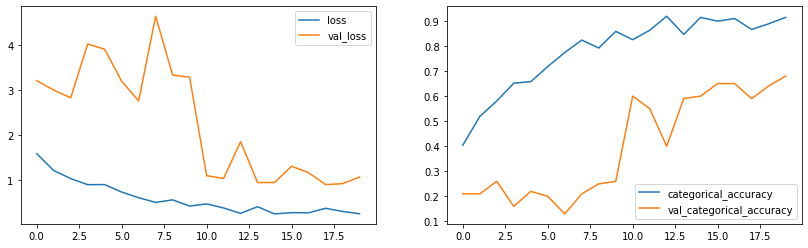

In [39]:
plot_accuracy(history_model1)

As we clearly see model overfit with training accuracy 91 but validation 68%

## Conv3D - Model 2  

#### Batch Size 30 and epoch= 25 with  fileter size (2,2,2)

In [19]:
img_height = 120
img_width = 120
frame_to_sample = 20
batch_size = 30
num_epochs = 25

model = get_model(filtersize=(2,2,2),dropout=0.5,dense_neurons=256)
print("Total Parameter:", model.count_params())
history_model2 =train_model(model)

Total Parameter: 926389
Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  /home/datasets/Project_data/train ; batch size = 30
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.9650 - categorical_accuracy: 0.3710Source path =  /home/datasets/Project_data/val ; batch size = 30
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]

Epoch 00001: saving model to model_init_2021-06-2508_08_43.861333/model-00001-1.96501-0.37104-1.96935-0.24000.h5
23/23 [==============================] - 94s 4s/step - loss: 1.9650 - categorical_accuracy: 0.3710 - val_loss: 1.9694 - val_categorical_accuracy: 0.2400
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.2336 - categorical_accuracy: 0.5732
Epoch 00002: saving model to model_init_2021-06-2508_08_43.861333/model-00002-1.23356-0.57315-2.36629-0.17000.h5
23/23 [==============================] - 96s 4s/step 

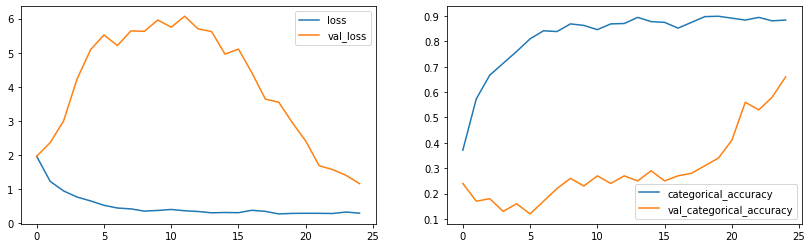

In [29]:
plot_accuracy(history_model2)

As we can see parameter size has reduced to 926389 with training accuracy 88% and validation accuracy 66%

## Conv3D - Model 3  

#### Batch Size 30 and epoch= 25 with  adding some more layer

In [ ]:
def get_model_with_more_layer(filtersize=(3,3,3),dropout=0.25,dense_neurons=64):
    
    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
                     input_shape=(frame_to_sample,img_height,img_width,num_channel)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
                     input_shape=(frame_to_sample,img_height,img_width,num_channel)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
        
    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_class,activation='softmax'))
    optimiser = 'adam'  #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


In [ ]:
img_height = 120
img_width = 120
frame_to_sample = 20
batch_size = 30
num_epochs = 20

model = get_model_with_more_layer(filtersize=(3,3,3),dropout=0.5,dense_neurons=256)
print("Summary")
model.summary()
print("-"*50)
print("Total Parameter:", model.count_params())
history_model3 = train_model(model)


Summary
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_10 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 10, 60, 60

In [ ]:
plot_accuracy(history_model3)

 By adding more layer training accurracy 81% and validation 58% . So no performance improvement after adding layer.

## Conv3D - Model 4  

#### Let add dropout in model 3 ( with  adding some more layer) . Batch Size 30 and epoch= 15 

In [18]:
def get_model_with_more_layer_and_dropout(filtersize=(3,3,3),dropout=0.25,dense_neurons=64):
    
    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
                     input_shape=(frame_to_sample,img_height,img_width,num_channel)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model = Sequential()
    model.add(Conv3D(16, filtersize, padding='same',
                     input_shape=(frame_to_sample,img_height,img_width,num_channel)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv3D(32, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))
    
    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
        
    model.add(Conv3D(64, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv3D(128, filtersize, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout*2))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_class,activation='softmax'))
    optimiser = 'adam'  #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model


In [32]:
img_height = 120
img_width = 120
frame_to_sample = 20
batch_size = 30
num_epochs = 15

model = get_model_with_more_layer_and_dropout(filtersize=(3,3,3),dropout=0.25,dense_neurons=256)
print("Summary")
model.summary()
print("-"*50)
print("Total Parameter:", model.count_params())
history_model4 = train_model(model)


Summary
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_26 (Activation)   (None, 10, 60, 60

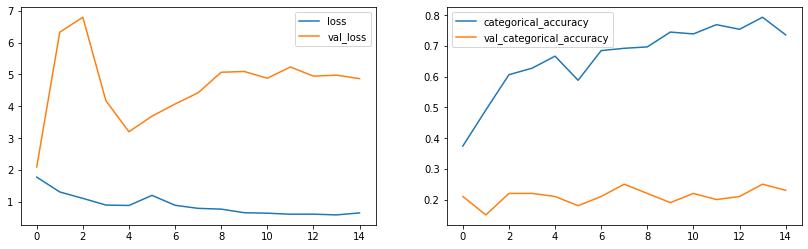

In [33]:
plot_accuracy(history_model4)

 Adding dropout further reduced validation accuracy and overfit 

## Conv3D - Model 5 

#### With Batch Size 20 and epoch= 25 & Try with reducing number of parameter

In [19]:
def get_model_redu(dropout=0.25,dense_neurons=64):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(frame_to_sample,img_height,img_width,num_channel)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(num_class,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
img_height = 120
img_width = 120
frame_to_sample = 16
batch_size = 20
num_epochs = 25

model = get_model_redu(dropout=0.25,dense_neurons=64)
print("Summary")
model.summary()
print("-"*50)
print("Total Parameter:", model.count_params())
history_model5= train_model(model)


Summary
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_5 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 60, 60,

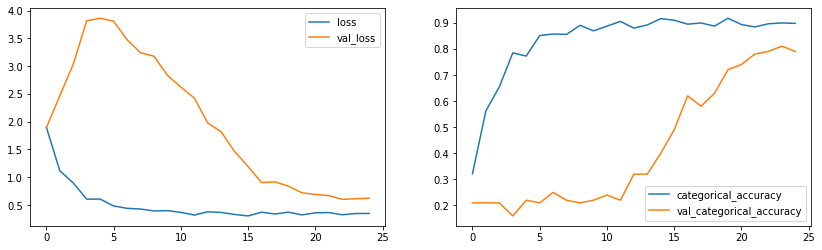

In [25]:
plot_accuracy(history_model5)

With reducing no of param we can see some improvement with train accuracy 87 and val accuracy 81%

## Convolutions + RNN - Model 6

####   CNN  LSTM model

In [26]:
def get_model_rnn(lstm_cel=64,dropout=0.25,dense_neurons=64,filter_size=(3,3)):
        
        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, filter_size , padding='same', activation='relu'),
                                  input_shape=(frame_to_sample,img_height,img_width,num_channel)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, filter_size , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, filter_size , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, filter_size , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, filter_size , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cel))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(num_class, activation='softmax'))
        optimiser = 'adam'  #write your optimizer
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
img_height = 120
img_width = 120
frame_to_sample = 20
batch_size = 20
num_epochs = 25

model = get_model_rnn(lstm_cel=128,dropout=0.25,dense_neurons=128)
print("Summary")
model.summary()
print("-"*50)
print("Total Parameter:", model.count_params())
train_model(model)

Summary
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 25, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 25, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 25, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 25, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 25, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 25, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 25, 30, 30

With CNN+RNN we get best training 98% and val accuracy 75%

Till now Model 1- 5 we see mostly failing with overfitting. Lets add data augmentation with these models. Specially, with Image rotation .

### Data Augmentation on model 1-5 and check model performance

In [33]:
def single_batch_data(source_path, t, batch,batch_size,img_idx,is_augmentation,remaining_seq=0):
            seq_len = remaining_seq if remaining_seq else batch_size
            batch_data = np.zeros((seq_len,len(img_idx),img_height,img_width,num_channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((seq_len,num_class)) # batch_labels is the one hot representation of the output
           
            if (is_augmentation): 
                batch_data_augmentation = np.zeros((seq_len,len(img_idx),img_height,img_width,num_channel))

        
            for folder in range(seq_len): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = imresize(image, (img_height, img_width,3))
                    
                    batch_data[folder,idx,:,:,0] = image_resized[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_resized[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_resized[:,:,2]/255#normalise and feed in the image
                    
                    if(is_augmentation):
                        num_rows, num_cols = image.shape[:2] 
                        translation_matrix = np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]])  
                        
                        img_translation = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
                        
                        gray_img = cv2.cvtColor(img_translation, cv2.COLOR_BGR2GRAY)
                        
                        x0, y0 = np.argwhere(gray_img > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray_img > 0).max(axis=0) 
                        
                        crop_img=img_translation[x0:x1,y0:y1,:]
                        
                        image_resized = imresize(crop_img, (img_height, img_width,3))
                        
                        rota = cv2.getRotationMatrix2D((img_width//2,img_height//2),np.random.randint(-10,10), 1.0)
                        rotated = cv2.warpAffine(image_resized, rota, (img_width, img_height))
                    
                        batch_data_augmentation[folder,idx,:,:,0] = rotated[:,:,0]/255 #normalise and feed in the image
                        batch_data_augmentation[folder,idx,:,:,1] = rotated[:,:,1]/255#normalise and feed in the image
                        batch_data_augmentation[folder,idx,:,:,2] = rotated[:,:,2]/255#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            if (is_augmentation):
                batch_data=np.concatenate([batch_data,batch_data_augmentation])
                batch_labels=np.concatenate([batch_labels,batch_labels])
                
            return(batch_data,batch_labels)

Source path =  /home/datasets/Project_data/val ; batch size = 5
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]


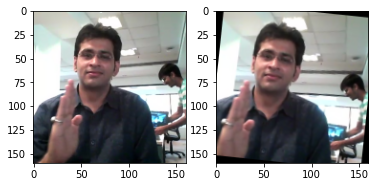

In [34]:
# Test generation with Rotation

batch_size=5

gen_val = generator(val_path,val_doc,batch_size,is_augmentation=True)
batch_data,batch_label = next(gen_val)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,10,:,:,:])   
axes[1].imshow(batch_data[5,10,:,:,:])
# Cropping working fine lets move to next.

# Model 7 - Conv3D Model 1 with Augmentation

In [35]:
img_height = 160
img_width = 160
frame_to_sample = 20
batch_size = 20
num_epochs = 20

model = get_model()
print("Total Parameter:", model.count_params())
history_model7=train_model(model,augment = True)

Total Parameter: 1940677
Source path =  /home/datasets/Project_data/train ; batch size = 20
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6349 - categorical_accuracy: 0.3967Source path =  /home/datasets/Project_data/val ; batch size = 20
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]

Epoch 00001: saving model to model_init_2021-06-2708_12_54.608917/model-00001-1.63490-0.39668-3.43921-0.16000.h5
34/34 [==============================] - 201s 6s/step - loss: 1.6349 - categorical_accuracy: 0.3967 - val_loss: 3.4392 - val_categorical_accuracy: 0.1600
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2116 - categorical_accuracy: 0.5279
Epoch 00002: saving model to model_init_2021-06-2708_12_54.608917/model-00002-1.21157-0.52790-2.82619-0.26000.h5
34/34 [==============================] - 207s 6s/step - loss: 1.2116 - categorical_accuracy: 0.5279 - val_loss: 2.8262 - val_ca

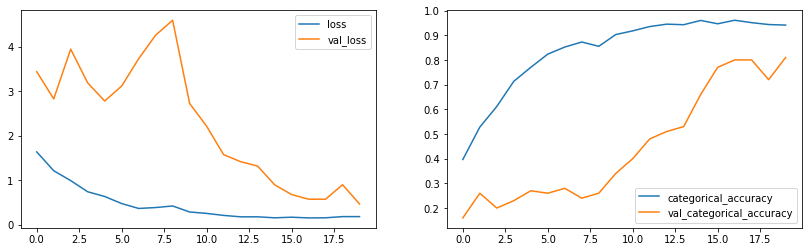

In [36]:
plot_accuracy(history_model7)

# Model 8 - Conv3D - Model 2 with Augmentation

In [20]:
img_height = 120
img_width = 120
frame_to_sample = 20
batch_size = 30
num_epochs = 25

model = get_model(filtersize=(2,2,2),dropout=0.5,dense_neurons=256)
print("Total Parameter:", model.count_params())
history_model8 =train_model(model,augment = True)

Total Parameter: 926389
Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  /home/datasets/Project_data/train ; batch size = 30
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.8422 - categorical_accuracy: 0.4080Source path =  /home/datasets/Project_data/val ; batch size = 30
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]

Epoch 00001: saving model to model_init_2021-06-2522_51_33.923189/model-00001-1.84216-0.40799-2.04802-0.16000.h5
23/23 [==============================] - 172s 7s/step - loss: 1.8422 - categorical_accuracy: 0.4080 - val_loss: 2.0480 - val_categorical_accuracy: 0.1600
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.3223 - categorical_accuracy: 0.5392
Epoch 00002: saving model to model_init_2021-06-2522_51_33.923189/model-00002-1.32229-0.53922-4.56508-0.14000.h5
23/23 [==============================] - 176s 8s/ste

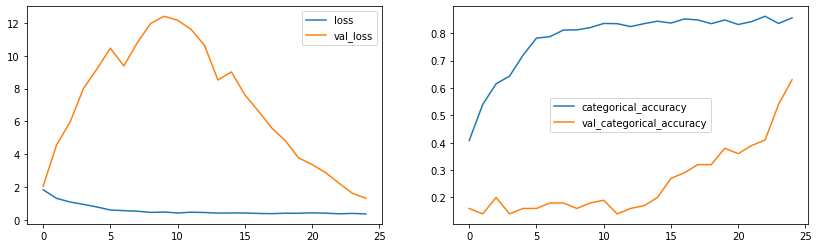

In [23]:
plot_accuracy(history_model8)

# Model 9 - Conv3D - Model 3 with Augmentation

In [29]:
img_height = 120
img_width = 120
frame_to_sample = 20
batch_size = 30
num_epochs = 20

model = get_model_with_more_layer(filtersize=(3,3,3),dropout=0.5,dense_neurons=256)
print("Summary")
model.summary()
print("-"*50)
print("Total Parameter:", model.count_params())
history_model9 = train_model(model,augment = True)

Summary
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_10 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 10, 60, 60

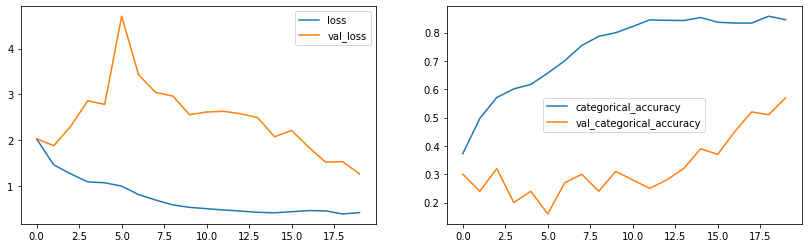

In [30]:
plot_accuracy(history_model9)

# Model 10 - Conv3D - Model 4 with Augmentation

In [22]:
img_height = 120
img_width = 120
frame_to_sample = 20
batch_size = 30
num_epochs = 20

model = get_model_with_more_layer_and_dropout(filtersize=(3,3,3),dropout=0.25,dense_neurons=256)
print("Summary")
model.summary()
print("-"*50)
print("Total Parameter:", model.count_params())
history_model10 = train_model(model,augment = True)





Summary
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_14 (Activation)   (None, 10, 60, 60

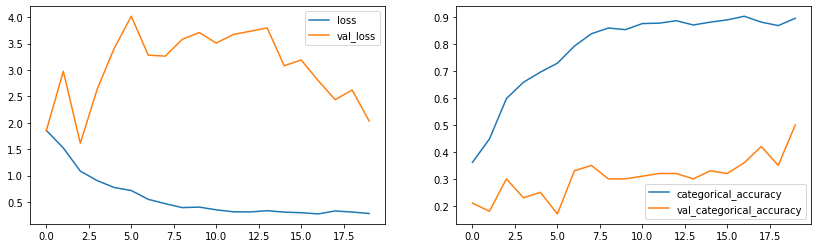

In [23]:
plot_accuracy(history_model10)

# Model 11 - Conv3D - Model 5 with Augmentation

In [25]:

img_height = 120
img_width = 120
frame_to_sample = 17
batch_size = 20
num_epochs = 25

model = get_model_redu(dropout=0.25,dense_neurons=64)
print("Summary")
model.summary()
print("-"*50)
print("Total Parameter:", model.count_params())
history_model11= train_model(model,augment = True)

Summary
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 17, 120, 120, 16)  1312      
_________________________________________________________________
activation_20 (Activation)   (None, 17, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 17, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_21 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 8, 60, 60,

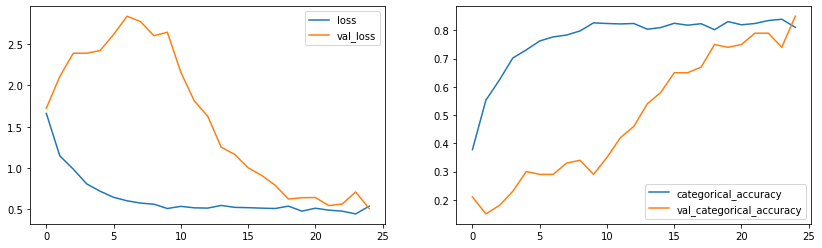

In [26]:
plot_accuracy(history_model11)

After checking all model we finalize model 6 ie model with RNN+CNN
- Training accuracy 98% and val accuracy 75%
- Trainable param 1,657,445